Reading data from ComplexData S3 buckets and getting familiar with structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
import json
import os
import re
import uuid

from itertools import product 

import boto3

from dotenv import load_dotenv
from tqdm import tqdm

## Load credentials

In [2]:
load_dotenv()

True

In [3]:
region_name = os.getenv("COMPLEXDATA_DEFAULT_REGION")
aws_access_key_id = os.getenv("COMPLEXDATA_S3_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("COMPLEXDATA_S3_SECRET_ACCESS_KEY")
aws_session_token = os.getenv("COMPLEXDATA_S3_SESSION_TOKEN")

In [4]:
s3_client = boto3.client(
    's3',
    region_name=region_name,
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    aws_session_token=aws_session_token,
)

## Query

In [ ]:
# # Example: List all buckets
# buckets = s3_client.list_buckets()
# bucket_names = []
# print("Buckets:")
# for bucket in buckets.get('Buckets', []):
#     print(f" - {bucket['Name']}")
#     bucket_names.append(bucket['Name'])

Buckets:
 - bluesky-misinfo
 - reddit-misinfo
 - x-misinfo


In [ ]:
# key = '2025/03/01/00/x-1-2025-03-01-00-01-57-ff8f6d7a-957b-4377-b2d7-2ca7bacc2408'
# obj = s3_client.get_object(Bucket='x-misinfo', Key=key)
# obj_bytes = obj['Body'].read()
# data = obj_bytes.decode('utf-8')
# print(f"Data from {key}:\n{data}\n")

Data from 2025/03/01/00/x-1-2025-03-01-00-01-57-ff8f6d7a-957b-4377-b2d7-2ca7bacc2408:
{"data": {"article": {}, "attachments": {}, "author_id": "3040308948", "context_annotations": [{"domain": {"id": "10", "name": "Person", "description": "Named people in the world like Nelson Mandela"}, "entity": {"id": "1052324708752883712", "name": "Yashar Ali", "description": "Yashar Ali"}}, {"domain": {"id": "94", "name": "Journalist", "description": "A journalist like 'Anderson Cooper'"}, "entity": {"id": "1052324708752883712", "name": "Yashar Ali", "description": "Yashar Ali"}}, {"domain": {"id": "131", "name": "Unified Twitter Taxonomy", "description": "A taxonomy of user interests. "}, "entity": {"id": "1046545033657081857", "name": "News", "description": "News"}}, {"domain": {"id": "131", "name": "Unified Twitter Taxonomy", "description": "A taxonomy of user interests. "}, "entity": {"id": "1052324708752883712", "name": "Yashar Ali", "description": "Yashar Ali"}}, {"domain": {"id": "131", "nam

## Load 1-day worth of data from BlueSky, Reddit, and X

In [ ]:
# # Pull data from specified buckets and dates
# buckets = [
#     'bluesky-misinfo',
#     'reddit-misinfo',
#     'x-misinfo',
# ]
# years = ['2025']
# months = ['03']
# days = ['01']
# hours = [
#     '00', #'01', '02', '03', '04', '05',
#     # '06', '07', '08', '09', '10', '11',
#     # '12', '13', '14', '15', '16', '17',
#     # '18', '19', '20', '21', '22', '23',
# ]

# bucket2file2data = {}

# for bucket in buckets:
#     bucket2file2data[bucket] = {}
#     for date in product(years, months, days, hours):
#         dir_path = '/'.join(p)
#         files = s3_client.list_objects_v2(Bucket=bucket, Prefix=dir_path)
#         for file in tqdm(files['Contents']):
#             # Load file
#             file_key = file['Key']
#             obj = s3_client.get_object(Bucket=bucket, Key=file_key)
#             obj_bytes = obj['Body'].read()
#             data = obj_bytes.decode('utf-8')

#             bucket2file2data[bucket][file_key] = data
#         print(f'Finished: {date}')
#     print(f'Bucket: {bucket}; # of files: {len(bucket2file2data[bucket])}')

100%|██████████| 667/667 [05:13<00:00,  2.13it/s]


Finished: ('2025', '03', '01', '00')
Bucket: bluesky-misinfo; # of files: 667


100%|██████████| 242/242 [00:41<00:00,  5.87it/s]


Finished: ('2025', '03', '01', '00')
Bucket: reddit-misinfo; # of files: 242


100%|██████████| 282/282 [01:12<00:00,  3.91it/s]

Finished: ('2025', '03', '01', '00')
Bucket: x-misinfo; # of files: 282


In [5]:
def escape_newlines_in_json(json_str):
    return json_str.replace('\n', '\\n')

def load_jsonl_str(json_str):
    # Split into newlines and load as list of Python dicts
    json_chunks = re.split(r'\n(?=\{)', json_str.strip())

    data_objects = []
    for chunk in json_chunks:
        escaped_chunk = escape_newlines_in_json(chunk)
        try:
            obj = json.loads(escaped_chunk)
            data_objects.append(obj)
        except json.JSONDecodeError as e:
            print("Error decoding a chunk:", e)
    
    return data_objects

In [77]:
# Convert to dataframe
bucket = 'reddit-misinfo'
df_reddit = pd.DataFrame({
    'bucket': [bucket]*len(bucket2file2data[bucket]),
    'file': bucket2file2data[bucket].keys(),
    'data': [
        load_jsonl_str(bucket2file2data[bucket][key])
        for key in list(bucket2file2data[bucket].keys())
    ]
})
print(df_reddit.shape)

(242, 3)


In [78]:
# Convert to dataframe
bucket = 'x-misinfo'
df_x = pd.DataFrame({
    'bucket': [bucket]*len(bucket2file2data[bucket]),
    'file': bucket2file2data[bucket].keys(),
    'data': [
        load_jsonl_str(bucket2file2data[bucket][key])
        for key in list(bucket2file2data[bucket].keys())
    ]
})
print(df_x.shape)

(282, 3)


In [79]:
# Convert to dataframe
bucket = 'bluesky-misinfo'
df_bluesky = pd.DataFrame({
    'bucket': [bucket]*len(bucket2file2data[bucket]),
    'file': bucket2file2data[bucket].keys(),
    'data': [
        load_jsonl_str(bucket2file2data[bucket][key])
        for key in list(bucket2file2data[bucket].keys())
    ]
})
print(df_bluesky.shape)

(667, 3)


### Postprocessing

In [102]:
pd.set_option('display.max_columns', 50)

In [95]:
# Explode jsonl and melt data
df_exploded = df_x.explode('data').reset_index(drop=True)
df_exploded['data_idx'] = df_exploded.groupby(['bucket', 'file']).cumcount()
data_norm = pd.json_normalize(df_exploded['data'])
df_x_norm = pd.concat([df_exploded.drop(columns=['data']), data_norm], axis=1)
print(df_x_norm.shape)

(17274, 49)


In [96]:
# Explode jsonl and melt data
df_exploded = df_reddit.explode('data').reset_index(drop=True)
df_exploded['data_idx'] = df_exploded.groupby(['bucket', 'file']).cumcount()
data_norm = pd.json_normalize(df_exploded['data'])
df_reddit_norm = pd.concat([df_exploded.drop(columns=['data']), data_norm], axis=1)
print(df_reddit_norm.shape)

(47802, 46)


In [97]:
# Explode jsonl and melt data
df_exploded = df_bluesky.explode('data').reset_index(drop=True)
df_exploded['data_idx'] = df_exploded.groupby(['bucket', 'file']).cumcount()
data_norm = pd.json_normalize(df_exploded['data'])
df_bluesky_norm = pd.concat([df_exploded.drop(columns=['data']), data_norm], axis=1)
print(df_bluesky_norm.shape)

(7270126, 271)


### View

In [104]:
df_x_norm['data.context_annotations'].iloc[0]

[{'domain': {'id': '10',
   'name': 'Person',
   'description': 'Named people in the world like Nelson Mandela'},
  'entity': {'id': '1052324708752883712',
   'name': 'Yashar Ali',
   'description': 'Yashar Ali'}},
 {'domain': {'id': '94',
   'name': 'Journalist',
   'description': "A journalist like 'Anderson Cooper'"},
  'entity': {'id': '1052324708752883712',
   'name': 'Yashar Ali',
   'description': 'Yashar Ali'}},
 {'domain': {'id': '131',
   'name': 'Unified Twitter Taxonomy',
   'description': 'A taxonomy of user interests. '},
  'entity': {'id': '1046545033657081857',
   'name': 'News',
   'description': 'News'}},
 {'domain': {'id': '131',
   'name': 'Unified Twitter Taxonomy',
   'description': 'A taxonomy of user interests. '},
  'entity': {'id': '1052324708752883712',
   'name': 'Yashar Ali',
   'description': 'Yashar Ali'}},
 {'domain': {'id': '131',
   'name': 'Unified Twitter Taxonomy',
   'description': 'A taxonomy of user interests. '},
  'entity': {'id': '107475536953

In [105]:
df_x_norm['data.entities.annotations'].iloc[0]

[{'start': 29,
  'end': 37,
  'probability': 0.9061,
  'type': 'Person',
  'normalized_text': 'Netanyahu'}]

In [106]:
df_x_norm['data.text'].iloc[0]

'@yashar I was looking to see Netanyahu’s response but I’m not surprised, he has his own crisis going on as well and also the orange man is his friend so never mind.'

In [109]:
df_reddit_norm['body'].iloc[0]

'Amen! Also… I thought I was the only person on the planet whose favourite pizza was Kraft pizza, nice!'

In [113]:
df_reddit_norm[df_reddit_norm['text'].notna()]['text'].iloc[0]

"Anyone notice the Kraft Pizza Kits changed their sauce? I can tolerate a lot like rising heating costs, threats of invasion from the USA and paper straws but don't mess with my favorite pizza!"

In [143]:
df_bluesky_norm['commit.record.body'].value_counts()[:10]

commit.record.body
# Test\nTest post, do not like.\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [131]:
df_bluesky_norm['commit.record.title'].value_counts()[:10]

commit.record.title
2025/02/28 とのフラ 違法日記                                                    6
                                                                        1
ATプロトコルコミュニティファンドのご紹介                                                   1
文字起こし                                                                   1
'Be Thankful!' Trump Berates Zelensky in Insane Oval Office Meltdown    1
There Is No Antimemetics Divisionのあらすじを探して日本語訳して                        1
There Is No Antimemetics Divisionあらすじ                                   1
2025/02/28                                                              1
bob                                                                     1
Name: count, dtype: int64

# Extraction

## IsaNLP RST Parser
`isnlp_rst` on PyPI  
And `pip install git+https://github.com/iinemo/isanlp.git`

https://huggingface.co/tchewik/isanlp_rst_v3

In [6]:
from isanlp_rst.parser import Parser

/nas/ckgfs/users/eboxer/complexdata/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Define the version of the model you want to use
# 'gumrrg' is multilingual (English and Russian), 'rstdt' is monolingual English
version = 'gumrrg'

# Initialize the parser with the desired version
parser = Parser(
    hf_model_name='tchewik/isanlp_rst_v3',
    hf_model_version=version,
    cuda_device=0
)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/nas/ckgfs/users/eboxer/complexdata/env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [8]:
# Example text for parsing
text = """
On Saturday, in the ninth edition of the T20 Men's Cricket World Cup, Team India won against South Africa by seven runs. 
The final match was played at the Kensington Oval Stadium in Barbados. This marks India's second win in the T20 World Cup, 
which was co-hosted by the West Indies and the USA between June 2 and June 29.

After winning the toss, India decided to bat first and scored 176 runs for the loss of seven wickets. 
Virat Kohli top-scored with 76 runs, followed by Axar Patel with 47 runs. Hardik Pandya took three wickets, 
and Jasprit Bumrah took two wickets.
"""

# Parse the text to obtain the RST tree
res = parser(text)  # res['rst'] contains the binary discourse tree

# Display the structure of the RST tree
res['rst'][0].to_rs3('temp.rs3')

## KeyBERT
https://github.com/wjbmattingly/keyword-spacy?tab=readme-ov-file

In [183]:
from keybert import KeyBERT

In [184]:
doc = """
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs. It infers a
         function from labeled training data consisting of a set of training examples.
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal).
         A supervised learning algorithm analyzes the training data and produces an inferred function,
         which can be used for mapping new examples. An optimal scenario will allow for the
         algorithm to correctly determine the class labels for unseen instances. This requires
         the learning algorithm to generalize from the training data to unseen situations in a
         'reasonable' way (see inductive bias).
      """
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(doc)
keywords

[('supervised', 0.6676),
 ('labeled', 0.4896),
 ('learning', 0.4813),
 ('training', 0.4134),
 ('labels', 0.3947)]

## Run extractions

In [159]:
def parse_isanlp(text):
    if pd.isna(text):
        return None
    res = parser(text)
    return res

In [219]:
def parse_keybert(text):
    if pd.isna(text):
        return []
    res = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 3),
        stop_words='english',
        use_maxsum=True,
        nr_candidates=20,
        top_n=5,
    )
    return res

### X

In [274]:
df_x_norm.shape

(17274, 52)

In [199]:
df_x_norm.loc[:,'data.text.isanlp'] = df_x_norm['data.text'].apply(parse_isanlp)
df_x_norm['data.text.isanlp'].notna().mean()

np.float64(1.0)

In [276]:
17274 / (13 * 60 + 14)

21.75566750629723

In [ ]:
# Rerun for analysis
# df_x_norm.loc[:,'data.text.keybert'] = df_x_norm['data.text'].apply(parse_keybert)
# df_x_norm['data.text.keybert'].notna().mean()

In [208]:
fname = './data/processed/df_x_norm_20250301_parsed_keywords.pkl'
df_x_norm.to_pickle(fname)
print('Wrote to:', fname)

Wrote to: ./data/processed/df_x_norm_20250301_parsed_keywords.pkl


### Reddit

In [275]:
df_reddit_norm.shape

(47802, 48)

In [202]:
df_reddit_norm.loc[:,'body.isanlp'] = df_reddit_norm['body'].apply(parse_isanlp)
df_reddit_norm['body.isanlp'].notna().mean()

Token indices sequence length is longer than the specified maximum sequence length for this model (840 > 512). Running this sequence through the model will result in indexing errors


np.float64(0.9735994309861512)

In [277]:
47802 / (38 * 60 + 11)

20.865124399825405

In [203]:
# df_reddit_norm.loc[:,'body.keybert'] = df_reddit_norm['body'].apply(parse_keybert)
# df_reddit_norm['body.keybert'].notna().mean()

KeyboardInterrupt: 

In [ ]:
# df_reddit_norm.loc[:,'text.isanlp'] = df_reddit_norm['text'].apply(parse_isanlp)
# df_reddit_norm['text.isanlp'].notna().mean()

In [ ]:
# df_reddit_norm.loc[:,'text.keybert'] = df_reddit_norm['text'].apply(parse_keybert)
# df_reddit_norm['text.keybert'].notna().mean()

In [204]:
fname = './data/processed/df_reddit_norm_20250301_parsed_keywords.pkl'
df_reddit_norm.to_pickle(fname)
print('Wrote to:', fname)

Wrote to: ./data/processed/df_reddit_norm_20250301_parsed_keywords.pkl


### BlueSky

In [ ]:
# df_reddit_norm.loc[:,'commit.record.body.isanlp'] = df_reddit_norm['commit.record.body'].apply(parse_isanlp)
# df_reddit_norm['commit.record.body.isanlp'].notna().mean()

In [ ]:
# df_reddit_norm.loc[:,'commit.record.body.keybert'] = df_reddit_norm['commit.record.body'].apply(parse_keybert)
# df_reddit_norm['commit.record.body.keybert'].notna().mean()

# Analysis

In [239]:
# Get heights of RST trees
def get_rst_height(rst):
    if rst is None:
        return 0

    # Recursion on left and right sub-trees
    left_height = get_rst_height(rst.left)
    right_height = get_rst_height(rst.right)

    return 1 + max(left_height, right_height)

Text(0.5, 1.0, 'Heights of RST trees: X text 2025-03-01')

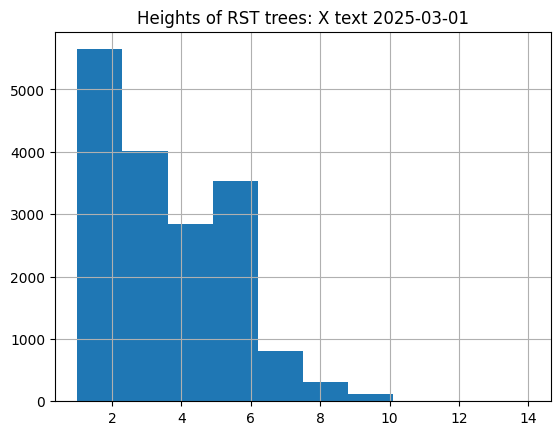

In [272]:
df_x_norm.loc[:,'data.text.isanlp_rst_height'] = df_x_norm['data.text.isanlp']\
    .apply(lambda x: get_rst_height(x['rst'][0]))
df_x_norm.loc[:,'data.text.isanlp_rst_height'].hist(bins=10)
plt.title('Heights of RST trees: X text 2025-03-01')

Text(0.5, 1.0, 'Heights of RST trees: Reddit body text 2025-03-01')

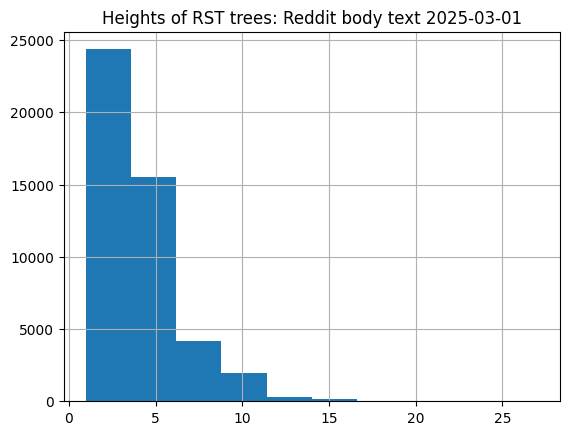

In [273]:
df_reddit_norm.loc[:,'body.isanlp_rst_height'] = df_reddit_norm['body.isanlp']\
    .apply(lambda x: get_rst_height(x['rst'][0]) if x else None)
df_reddit_norm.loc[:,'body.isanlp_rst_height'].hist(bins=10)
plt.title('Heights of RST trees: Reddit body text 2025-03-01')

In [267]:
for row in df_x_norm[
        df_x_norm['data.text.isanlp_rst_height'] >= 12
    ].iterrows():
    row = row[1]
    obs_id = f"{row['bucket']}_{row['file']}_{row['data_idx']}".replace('/', '-')
    rst = row['data.text.isanlp']['rst'][0]
    rst.to_rs3(os.path.join('./assets/rst', f'{obs_id}.rs3'))
print('Exported rs3 files')

Exported rs3 files


In [271]:
for row in df_reddit_norm[
        df_reddit_norm['body.isanlp_rst_height'] >= 19
    ].iterrows():
    row = row[1]
    obs_id = f"{row['bucket']}_{row['file']}_{row['data_idx']}".replace('/', '-')
    rst = row['body.isanlp']['rst'][0]
    rst.to_rs3(os.path.join('./assets/rst', f'{obs_id}.rs3'))
print('Exported rs3 files')

Exported rs3 files
